<a href="https://colab.research.google.com/github/joeljo2201/modelevaluation/blob/main/modelevaluationtask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jeslago/epftoolbox.git


Cloning into 'epftoolbox'...
remote: Enumerating objects: 525, done.
remote: Total 525 (delta 0), reused 0 (delta 0), pack-reused 525
Receiving objects: 100% (525/525), 23.68 MiB | 22.27 MiB/s, done.
Resolving deltas: 100% (299/299), done.


In [ ]:
!cd epftoolbox

/content/epftoolbox


In [ ]:
!pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/epftoolbox
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for epftoolbox: filename=epftoolbox-1.0-py3-none-any.whl size=66419 sha256=be121a4cd6bf748934a0eb7a74d3833eea8e355b0dd05ea651fe8554b8e1286b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6yo69uns/wheels/06/b5/e7/02ff8b49a8bcb96199cd1c61796efa62c3e0a1a6a30807e150
Successfully built epftoolbox
  Attempting uninstall: epftoolbox
    Found existing installation: epftoolbox 1.0
    Uninstalling epftoolbox-1.0:
      Successfully uninstalled epftoolbox-1.0


In [ ]:
import pandas as pd
import numpy as np
import argparse
import os
from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import LEAR
from epftoolbox.data import read_data
from epftoolbox.evaluation import MAE, sMAPE
from epftoolbox.models import DNN

In [ ]:
# ------------------------------ EXTERNAL PARAMETERS ------------------------------------#


parser = argparse.ArgumentParser()

parser.add_argument("--dataset", type=str, default='PJM', 
                    help='Market under study. If it not one of the standard ones, the file name' +
                         'has to be provided, where the file has to be a csv file')

parser.add_argument("--years_test", type=int, default=1, 
                    help='Number of years (a year is 364 days) in the test dataset. Used if ' +
                    ' begin_test_date and end_test_date are not provided.')

parser.add_argument("--calibration_window", type=int, default=4*364, 
                    help='Number of days used in the training dataset for recalibration')

parser.add_argument("--begin_test_date", type=str, default='26/12/2017 0:0', 
                    help='Optional parameter to select the /test dataset. Used in combination with ' +
                         'end_test_date. If either of them is not provided, test dataset is built ' +
                         'using the years_test parameter. It should either be  a string with the ' +
                         ' following format d/m/Y H:M')

parser.add_argument("--end_test_date", type=str, default='26/01/2018 0:0', 
                    help='Optional parameter to select the test dataset. Used in combination with ' +
                         'begin_test_date. If either of them is not provided, test dataset is built ' +
                         'using the years_test parameter. It should either be  a string with the ' +
                         ' following format d/m/Y H:M')
parser.add_argument('-f')
args = parser.parse_args()

dataset = args.dataset
years_test = args.years_test
calibration_window = args.calibration_window
begin_test_date = args.begin_test_date
end_test_date = args.end_test_date

path_datasets_folder = os.path.join('.', 'datasets')
path_recalibration_folder = os.path.join('.', '/content/epftoolbox/examples/experimental_files')

# Defining train and testing data
df_train, df_test = read_data(dataset=dataset, years_test=years_test, path=path_datasets_folder,
                              begin_test_date=begin_test_date, end_test_date=end_test_date)

# Defining unique name to save the forecast
forecast_file_name = 'fc_nl' + '_dat' + str(dataset) + '_YT' + str(years_test) + \
                     '_CW' + str(calibration_window) + '.csv'

forecast_file_path = os.path.join(path_recalibration_folder, forecast_file_name)


# Defining empty forecast array and the real values to be predicted in a more friendly format
forecast = pd.DataFrame(index=df_test.index[::24], columns=['h' + str(k) for k in range(24)])
real_values = df_test.loc[:, ['Price']].values.reshape(-1, 24)
real_values = pd.DataFrame(real_values, index=forecast.index, columns=forecast.columns)

forecast_dates = forecast.index

model = LEAR(calibration_window=calibration_window)



df = pd.DataFrame({'MAE' : [], 'SMAE':[]})
# For loop over the recalibration dates
for date in forecast_dates:

    ls=[]
    # For simulation purposes, we assume that the available data is
    # the data up to current date where the prices of current date are not known
    data_available = pd.concat([df_train, df_test.loc[:date + pd.Timedelta(hours=23), :]], axis=0)

    # We set the real prices for current date to NaN in the dataframe of available data
    data_available.loc[date:date + pd.Timedelta(hours=23), 'Price'] = np.NaN

    # Recalibrating the model with the most up-to-date available data and making a prediction
    # for the next day
    Yp = model.recalibrate_and_forecast_next_day(df=data_available, next_day_date=date, 
                                                 calibration_window=calibration_window)
    # Saving the current prediction
    forecast.loc[date, :] = Yp

    # Computing metrics up-to-current-date
    mae = np.mean(MAE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) 
    smape = np.mean(sMAPE(forecast.loc[:date].values.squeeze(), real_values.loc[:date].values)) * 100
    ls=[mae,smape]
    df.loc[len(df.index)]=ls
    # Pringint information
    print('{} - sMAPE: {:.2f}%  |  MAE: {:.3f}'.format(str(date)[:10], smape, mae))

    # Saving forecast
    forecast.to_csv(forecast_file_path)
df.to_csv("Learerrorvalues.csv")


Test datasets: 2017-12-26 00:00:00 - 2018-01-26 23:00:00
2017-12-26 - sMAPE: 7.57%  |  MAE: 2.298
2017-12-27 - sMAPE: 10.26%  |  MAE: 3.659
2017-12-28 - sMAPE: 16.04%  |  MAE: 6.883
2017-12-29 - sMAPE: 20.70%  |  MAE: 9.560
2017-12-30 - sMAPE: 22.37%  |  MAE: 9.787
2017-12-31 - sMAPE: 21.99%  |  MAE: 9.416
2018-01-01 - sMAPE: 20.87%  |  MAE: 8.922
2018-01-02 - sMAPE: 22.97%  |  MAE: 10.890
2018-01-03 - sMAPE: 23.75%  |  MAE: 11.863
2018-01-04 - sMAPE: 23.58%  |  MAE: 12.297
2018-01-05 - sMAPE: 23.58%  |  MAE: 12.957
2018-01-06 - sMAPE: 27.69%  |  MAE: 14.332
2018-01-07 - sMAPE: 27.56%  |  MAE: 13.919
2018-01-08 - sMAPE: 26.62%  |  MAE: 13.323
2018-01-09 - sMAPE: 27.12%  |  MAE: 13.299
2018-01-10 - sMAPE: 27.63%  |  MAE: 13.032
2018-01-11 - sMAPE: 27.78%  |  MAE: 12.509
2018-01-12 - sMAPE: 26.78%  |  MAE: 11.962
2018-01-13 - sMAPE: 26.99%  |  MAE: 12.066
2018-01-14 - sMAPE: 27.52%  |  MAE: 12.405
2018-01-15 - sMAPE: 27.13%  |  MAE: 12.263
2018-01-16 - sMAPE: 26.29%  |  MAE: 11.874
2018-

In [ ]:
"""
Example for optimizing the hyperparameter and features of the DNN model
"""

# Author: Jesus Lago

# License: AGPL-3.0 License


from epftoolbox.models import hyperparameter_optimizer

# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = 'PJM'

# Number of years (a year is 364 days) in the test dataset.
years_test = 1

# Optional parameters for selecting the test dataset, if either of them is not provided, 
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = None
end_test_date = None

# Boolean that selects whether the validation and training datasets are shuffled
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new hyperparameter optimization or we restart an existing one
new_hyperopt = 1

# Number of years used in the training dataset for recalibration
calibration_window = 1

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Number of iterations for hyperparameter optimization
max_evals = 10

path_datasets_folder = "./datasets/"
path_hyperparameters_folder = "./experimental_files/"

# Check documentation of the hyperparameter_optimizer for each of the function parameters
# In this example, we optimize a model for the PJM market.
# We consider two directories, one for storing the datasets and the other one for the experimental files.
# We start a hyperparameter optimization from scratch. We employ 1500 iterations in hyperopt,
# 2 years of test data, a DNN with 2 hidden layers, a calibration window of 4 years,
# we avoid data augmentation,  and we provide an experiment_id equal to 1
hyperparameter_optimizer(path_datasets_folder=path_datasets_folder, 
                         path_hyperparameters_folder=path_hyperparameters_folder, 
                         new_hyperopt=new_hyperopt, max_evals=max_evals, nlayers=nlayers, dataset=dataset, 
                         years_test=years_test, calibration_window=calibration_window, 
                         shuffle_train=shuffle_train, data_augmentation=0, experiment_id=experiment_id,
                         begin_test_date=begin_test_date, end_test_date=end_test_date)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 1/20 iterations.
Best MAE - Validation Dataset
  MAE: 4.3 | sMAPE: 15.40 %

Best MAE - Test Dataset
  MAE: 6.3 | sMAPE: 22.01 %


Tested 2/20 iterations.
Best MAE - Validation Dataset
  MAE: 4.3 | sMAPE: 15.40 %

Best MAE - Test Dataset
  MAE: 6.3 | sMAPE: 22.01 %


Tested 3/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.8 | sMAPE: 10.72 %

Best MAE - Test Dataset
  MAE: 4.2 | sMAPE: 15.69 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 4/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.8 | sMAPE: 10.72 %

Best MAE - Test Dataset
  MAE: 4.2 | sMAPE: 15.69 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 5/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.8 | sMAPE: 10.72 %

Best MAE - Test Dataset
  MAE: 4.2 | sMAPE: 15.69 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 6/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 7/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 8/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


Tested 9/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 10/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 11/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 12/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 13/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 14/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 15/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 16/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 17/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 18/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)




Tested 19/20 iterations.
Best MAE - Validation Dataset
  MAE: 2.6 | sMAPE: 10.01 %

Best MAE - Test Dataset
  MAE: 4.3 | sMAPE: 15.48 %


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


datasets    examples		Learerrorvalues.csv  setup.cfg
docs	    experimental_files	LICENSE.txt	     setup.py
epftoolbox  forecasts		README.md


datasets  epftoolbox  experimental_files  LICENSE.txt  setup.cfg
docs	  examples    forecasts		  README.md    setup.py


In [ ]:

"""
Simplified example for using the DNN model for forecasting prices with daily recalibration
"""

# Author: Jesus Lago

# License: AGPL-3.0 License

from epftoolbox.models import evaluate_dnn_in_test_dataset
import os

# Number of layers in DNN
nlayers = 2

# Market under study. If it not one of the standard ones, the file name
# has to be provided, where the file has to be a csv file
dataset = 'PJM'

# Number of years (a year is 364 days) in the test dataset.
years_test = 1

# Boolean that selects whether the validation and training datasets were shuffled when
# performing the hyperparameter optimization. Note that it does not select whether
# shuffling is used for recalibration as for recalibration the validation and the
# training datasets are always shuffled.
shuffle_train = 1

# Boolean that selects whether a data augmentation technique for DNNs is used
data_augmentation = 0

# Boolean that selects whether we start a new recalibration or we restart an existing one
new_recalibration = 1

# Number of years used in the training dataset for recalibration
calibration_window = 1

# Unique identifier to read the trials file of hyperparameter optimization
experiment_id = 1

# Optional parameters for selecting the test dataset, if either of them is not provided,
# the test dataset is built using the years_test parameter. They should either be one of
# the date formats existing in python or a string with the following format
# "%d/%m/%Y %H:%M"
begin_test_date = '26/12/2017'
end_test_date = '28/12/2017'

# Set up the paths for saving data (this are the defaults for the library)
path_datasets_folder = os.path.join('.', 'datasets')
path_recalibration_folder = os.path.join('.', 'experimental_files')
path_hyperparameter_folder = os.path.join('.', 'experimental_files')

evaluate_dnn_in_test_dataset(experiment_id, path_hyperparameter_folder=path_hyperparameter_folder,
                               path_datasets_folder=path_datasets_folder, shuffle_train=shuffle_train,
                               path_recalibration_folder=path_recalibration_folder,
                               nlayers=nlayers, dataset=dataset, years_test=years_test,
                               data_augmentation=data_augmentation, calibration_window=calibration_window,
                               new_recalibration=new_recalibration, begin_test_date=begin_test_date,
                               end_test_date=end_test_date)

Test datasets: 2017-12-26 00:00:00 - 2017-12-28 23:00:00


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2017-12-26 - sMAPE: 8.31%  |  MAE: 2.577


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2017-12-27 - sMAPE: 14.80%  |  MAE: 5.240


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2017-12-28 - sMAPE: 21.41%  |  MAE: 8.760


,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9,...,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-26,23.006674,22.330263,22.220232,22.001255,22.49589,24.145916,29.791901,34.500774,33.230827,33.16703,...,29.746725,29.246964,31.49548,36.530518,37.136856,36.381432,35.397587,31.109636,26.555443,24.385332
2017-12-27,24.726645,23.83979,23.366009,23.217424,23.861103,25.610477,30.972563,35.260422,33.749977,34.194168,...,31.441628,31.513466,33.903721,39.948692,38.879402,37.603794,37.880608,33.421295,28.322048,24.75823
2017-12-28,24.81588,23.897818,23.572937,23.155376,23.696238,26.970592,33.770859,38.246811,36.929878,37.670074,...,36.589153,36.545536,38.349625,44.758575,42.594761,41.822662,41.313141,36.395588,29.382944,26.033188


In [ ]:
#after running lear model

import pandas as pd
# df2=pd.read_csv("DNNerrorvalues.csv")
df=pd.read_csv("Learerrorvalues.csv")
print(df.to_string(index=False))
# print(df2.to_string(index=False))

 Unnamed: 0       MAE      SMAE
          0  2.298473  7.572970
          1  3.658866 10.263977
          2  6.883241 16.041041
          3  9.560009 20.704499
          4  9.786644 22.369306
          5  9.415767 21.989390
          6  8.922184 20.872598
          7 10.890356 22.969314
          8 11.862798 23.750341
          9 12.296526 23.576713
         10 12.957405 23.579740
         11 14.331506 27.694617
         12 13.918607 27.557871
         13 13.322772 26.624158
         14 13.299193 27.123842
         15 13.032140 27.632856
         16 12.509289 27.784071
         17 11.961951 26.778855
         18 12.066191 26.985887
         19 12.404841 27.517428
         20 12.262762 27.127564
         21 11.873682 26.289080
         22 11.872276 26.183372
         23 11.656567 25.846349
         24 11.359895 25.382000
         25 11.016872 24.845589
         26 10.676963 24.212697
         27 10.420720 23.870856
         28 10.157713 23.402760
         29  9.877494 22.824022
        

Test datasets: 2016-12-27 00:00:00 - 2018-12-24 23:00:00


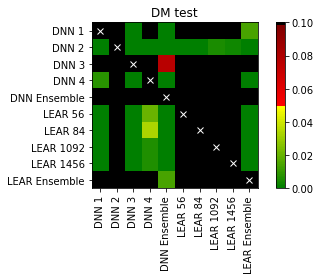

In [ ]:
from epftoolbox.evaluation import DM, plot_multivariate_DM_test
from epftoolbox.data import read_data
import pandas as pd
forecasts = pd.read_csv('https://raw.githubusercontent.com/jeslago/epftoolbox/master/forecasts/Forecasts_NP_DNN_LEAR_ensembles.csv', index_col=0)
del forecasts['Real price']
forecasts.index = pd.to_datetime(forecasts.index)
_, df_test = read_data(path='.', dataset='NP', begin_test_date=forecasts.index[0],end_test_date=forecasts.index[-1])
real_price = df_test.loc[:, ['Price']]
plot_multivariate_DM_test(real_price=real_price, forecasts=forecasts)